In [52]:
import numpy as np
from hottbox.core import Tensor
import yfinance as yf
import alphalens
import pandas as pd
from hottbox.pdtools import tensor_to_pd, pd_to_tensor
from hottbox.utils.generation import residual_tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error, mse, rmse, mape
from hottbox.rank import rank_estimation as re
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [53]:
# List of tickers we want. If None then all tickers are used.
ticks = sorted(["GOOG","AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", \
                  "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])
tickers = " ".join(ticks)

In [54]:
pan = yf.download(tickers, start="2011-05-20", end="2019-05-21")
returns = pan["Adj Close"].apply(np.log).diff(1)
returns = returns.stack()
returns.index = returns.index.set_names(['date', 'asset'])
returns = returns.unstack()
# returns.index = returns.index.tz_localize('UTC')
returns = returns.stack()
returns

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.015716
            ADBE    -0.002828
            AMAT    -0.016890
            AMD     -0.002318
            AMZN    -0.000755
                       ...   
2019-05-20  TSLA    -0.027236
            TXN     -0.019479
            V       -0.003786
            VZ       0.015714
            XLNX    -0.036255
Length: 40240, dtype: float64

In [55]:
pan = yf.download(tickers, start="2011-05-21", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-21", end="2019-05-21")

vol = pan["Volume"]
vol = vol.stack()
vol.index = vol.index.set_names(['date', 'asset'])
vol = vol.unstack()
vol = vol.stack()
vol.fillna(0)

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     337968400
            ADBE       3246700
            AMAT      17189500
            AMD       16694300
            AMZN       3381000
                       ...    
2019-05-20  TSLA     102631000
            TXN        7519900
            V          4747400
            VZ        20910600
            XLNX      10459300
Length: 40240, dtype: int64

In [56]:
pan = yf.download(tickers, start="2011-05-14", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-14", end="2019-05-21")

predictive_factor = pan['Open']
predictive_factor = -predictive_factor.pct_change(5)

predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

pricing = pan['Open'].iloc[1:]
pricing.index = pricing.index.tz_localize('UTC')

predictive_factor = predictive_factor.unstack()
# factor.index = factor.index.tz_localize('UTC')
predictive_factor = predictive_factor.stack()

predictive_factor.fillna(0)

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     0.017647
            ADBE     0.008112
            AMAT     0.050532
            AMD      0.038117
            AMZN     0.037676
                       ...   
2019-05-20  TSLA     0.125900
            TXN      0.055693
            V       -0.039188
            VZ      -0.042842
            XLNX     0.113267
Length: 40240, dtype: float64

In [57]:
pan = yf.download(tickers, start="2011-05-07", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")

non_predictive_factor = pan["Open"].pct_change(10)
non_predictive_factor = non_predictive_factor.stack()
non_predictive_factor.index = non_predictive_factor.index.set_names(['date', 'asset'])
non_predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.028969
            ADBE     0.064226
            AMAT    -0.062377
            AMD     -0.046667
            AMZN    -0.005776
                       ...   
2019-05-20  TSLA    -0.188865
            TXN     -0.096653
            V        0.032488
            VZ       0.040824
            XLNX    -0.121826
Length: 40240, dtype: float64

In [58]:
# 10-day Momentum

pan = yf.download(tickers, start="2011-05-07", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")
momentum = pan["Adj Close"].pct_change(10)
momentum = momentum.stack()
momentum.index = momentum.index.set_names(['date', 'asset'])
momentum

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.033000
            ADBE     0.057186
            AMAT    -0.074852
            AMD     -0.033632
            AMZN     0.005314
                       ...   
2019-05-20  TSLA    -0.195739
            TXN     -0.096064
            V        0.008882
            VZ       0.036901
            XLNX    -0.146862
Length: 40240, dtype: float64

In [59]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')
# Seaborn set plotting style.
sns.set_style("whitegrid")

# We are interested in the US stock-market.
market = 'us'

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

# %%time
hub = sf.StockHub(market=market, tickers=ticks, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices,
                 )

# %%time
df_val_signals_daily = hub.val_signals(variant='daily')

Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-income-ttm" on disk (13 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (13 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (13 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-4c3c6a0f.pickle' on disk (0 days old).
- Loading from disk ... Done!


In [60]:
# Price to book value
df_pbv = pd.DataFrame()
for i in ticks:
    df_pbv[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Price to Book Value"]
df_pbv.fillna(0,inplace=True)

df_pbv = df_pbv.stack()
df_pbv.index = df_pbv.index.set_names(['date', 'asset'])
df_pbv = df_pbv.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_pbv = df_pbv.stack()
df_pbv

date        asset
2011-05-20  AAPL      5.689950
            ADBE      3.387547
            AMAT      0.000000
            AMD       6.237374
            AMZN     13.197028
                       ...    
2019-05-20  TSLA      6.081886
            TXN      11.527985
            V        13.255717
            VZ        4.456760
            XLNX      9.745485
Length: 40240, dtype: float64

In [61]:
# Market Cap
df_mc = pd.DataFrame()
for i in ticks:
    df_mc[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Market-Cap"]
df_mc.fillna(0,inplace=True)

df_mc = df_mc.stack()
df_mc.index = df_mc.index.set_names(['date', 'asset'])
df_mc = df_mc.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_mc = df_mc.stack()
df_mc

date        asset
2011-05-20  AAPL     3.110468e+11
            ADBE     1.837882e+10
            AMAT     0.000000e+00
            AMD      6.318460e+09
            AMZN     9.058440e+10
                         ...     
2019-05-20  TSLA     3.501731e+10
            TXN      1.036827e+11
            V        4.519537e+11
            VZ       2.438293e+11
            XLNX     2.570074e+10
Length: 40240, dtype: float64

In [62]:
# P/E
df_pe = pd.DataFrame()
for i in ticks:
    df_pe[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["P/E"]
df_pe.fillna(0,inplace=True)

df_pe = df_pe.stack()
df_pe.index = df_pe.index.set_names(['date', 'asset'])
df_pe = df_pe.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_pe = df_pe.stack()
df_pe

date        asset
2011-05-20  AAPL     18.693842
            ADBE     20.834900
            AMAT      0.000000
            AMD      13.414989
            AMZN     78.632292
                       ...    
2019-05-20  TSLA    -35.875045
            TXN      18.581129
            V        42.018751
            VZ       15.702558
            XLNX     31.552038
Length: 40240, dtype: float64

In [63]:
from datetime import datetime

data = {'Date': list(returns.index.get_level_values('date')),
        'Asset': list(returns.index.get_level_values('asset')),
        'Returns': returns,
        'Volume': vol,
        'Predictive_Factor': predictive_factor,
        'Non_Predictive_Factor': non_predictive_factor,
        'Momentum': momentum,
        'Price_to_Book_Value': df_pbv.fillna(0),
        'Market_Cap': df_mc.fillna(0),
        'P/E': df_pe.fillna(0)
       }

#df_original = pd.DataFrame.from_dict(data)
#df_original.set_index(["Date","Asset","Returns","Volume","Predictive Factor","Non-Predictive Factor","Momentum","Price to book Value","Market Cap"], inplace=True)
df_original = pd.DataFrame({'Date': data['Date'], 'Asset': data['Asset'],'Returns': data['Returns'].values, 'Volume': data['Volume'].values, 'Predictive Factor': data['Predictive_Factor'].values, 'Non-Predictive Factor': data['Non_Predictive_Factor'].values, 'Momentum': data['Momentum'].values, 'Price to book Value': data['Price_to_Book_Value'].values,'Market Cap': data['Market_Cap'].values,'P/E': data['P/E'].values })
df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']] = StandardScaler().fit_transform(df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']])
df_original

,Date,Asset,Returns,Volume,Predictive Factor,Non-Predictive Factor,Momentum,Price to book Value,Market Cap,P/E
0,2011-05-20,AAPL,-0.810669,4.168913,0.481197,-0.585162,-0.658510,-0.139992,0.700790,-0.057583
1,2011-05-20,ADBE,-0.173128,-0.364434,0.269429,0.889262,0.762760,-0.335640,-0.730837,-0.048815
2,2011-05-20,AMAT,-0.868770,-0.175597,1.211508,-1.113715,-1.318071,-0.623497,-0.820739,-0.134140
3,2011-05-20,AMD,-0.147876,-0.182304,0.935784,-0.865164,-0.668471,-0.093475,-0.789831,-0.079201
4,2011-05-20,AMZN,-0.070571,-0.362615,0.926004,-0.218234,-0.054707,0.497923,-0.377633,0.187881
...,...,...,...,...,...,...,...,...,...,...
40235,2019-05-20,TSLA,-1.380555,0.981591,2.885304,-3.114880,-3.223169,-0.106688,-0.649447,-0.281058
40236,2019-05-20,TXN,-0.996818,-0.306559,1.326127,-1.655993,-1.652357,0.356096,-0.313561,-0.058045
40237,2019-05-20,V,-0.220504,-0.344109,-0.781031,0.387148,0.001530,0.502910,1.390056,0.037939
40238,2019-05-20,VZ,0.744101,-0.125200,-0.862175,0.519016,0.443080,-0.244783,0.371986,-0.069833


In [64]:
tensor = []
tensor_date = []
for i in range(len(df_original.loc[:,'Asset'])):
    if len(tensor_date)==len(ticks):
        tensor.append(tensor_date) 
        tensor_date = []
        
    tensor_date.append([df_original.loc[:,'Returns'].values[i], df_original.loc[:,'Volume'].values[i], df_original.loc[:,'Predictive Factor'].values[i], df_original.loc[:,'Non-Predictive Factor'].values[i], df_original.loc[:,'Momentum'].values[i], df_original.loc[:,'Price to book Value'].values[i], df_original.loc[:,'Market Cap'].values[i], df_original.loc[:,'P/E'].values[i]])  
    
    

In [65]:
np.array(tensor)

array([[[-8.10669048e-01,  4.16891323e+00,  4.81196980e-01, ...,
         -1.39992429e-01,  7.00790198e-01, -5.75831094e-02],
        [-1.73127734e-01, -3.64433585e-01,  2.69429060e-01, ...,
         -3.35639705e-01, -7.30836528e-01, -4.88148866e-02],
        [-8.68769989e-01, -1.75597463e-01,  1.21150825e+00, ...,
         -6.23497255e-01, -8.20739108e-01, -1.34139522e-01],
        ...,
        [-9.16874147e-01, -1.75238556e-01,  2.72496747e-01, ...,
         -2.20136248e-01, -2.27615748e-01,  2.67163327e-02],
        [-2.59093737e-01, -2.64369185e-01,  2.43212681e-01, ...,
         -5.20596638e-01, -3.05913745e-01,  3.49507304e-02],
        [-4.32679335e-01, -3.62170445e-01,  2.42395625e-01, ...,
         -2.46475821e-01, -7.73564416e-01, -7.14850104e-02]],

       [[-1.54417306e-01,  4.78693073e+00,  6.93591098e-01, ...,
         -1.41204220e-01,  6.96976842e-01, -5.77749801e-02],
        [-1.28172266e+00, -3.59576839e-01,  3.48469031e-01, ...,
         -3.42813725e-01, -7.33077090e

In [66]:
from corcondia import corcondia_3d
print(corcondia_3d(np.array(tensor), k=3))

83.16276227079723


In [67]:
tensor_data = Tensor(np.array(tensor))
print(tensor_data)

This tensor is of order 3 and consists of 321760 elements.
Sizes and names of its modes are (2011, 20, 8) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Training

In [68]:
alg = HOOI()
alg

HOOI(epsilon=0.01, init='hosvd', max_iter=50, process=(),
     random_state=None, tol=0.0001, verbose=False)

In [69]:
ml_rank = (2010, 20, 7)
tensor_tkd_hooi = alg.decompose(tensor_data, ml_rank)
print("\tOutput of the {} algorithm:".format(alg.name))
print(tensor_tkd_hooi)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd_hooi.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd_hooi.core)
tensor_tkd_hooi.core.data

	Output of the HOOI algorithm:
Tucker representation of a tensor with multi-linear rank=(2010, 20, 7).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (2011, 20, 8) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (2011, 2010)
Mode-1 factor matrix is of shape (20, 20)
Mode-2 factor matrix is of shape (8, 7)

	Core tensor
This tensor is of order 3 and consists of 281400 elements.
Sizes and names of its modes are (2010, 20, 7) and ['mode-0', 'mode-1', 'mode-2'] respectively.


array([[[-8.45590925e+00,  7.57333258e-01,  2.70041210e+01, ...,
         -2.93983052e+01, -1.37122993e+01,  5.33080140e-01],
        [-2.74539547e+00,  1.99619671e+02,  2.55694246e+01, ...,
         -9.82762849e+00, -1.65130871e+01, -1.01023401e-01],
        [ 8.83677030e+00, -4.06238791e+01, -3.12334406e+01, ...,
          3.06422025e+01, -6.16051104e+01,  5.97461677e-01],
        ...,
        [-3.03084466e+00, -5.49777738e-02,  2.14989904e+00, ...,
         -7.21512577e-01,  1.40890025e+00,  2.98683845e-01],
        [-1.97648559e-02, -2.06033517e+00, -2.57741239e+00, ...,
          4.43287981e+00,  8.27374592e-01,  6.77855225e-02],
        [ 1.06877444e+00, -1.15727615e+00, -3.87604231e+00, ...,
          3.56716844e+00,  1.43654781e+00, -4.36997548e-02]],

       [[ 7.99681682e+00,  8.73628932e+00, -3.66538794e+01, ...,
         -6.76162359e+01, -4.06581688e+00, -1.00406002e+00],
        [ 5.85575078e+00, -2.50449795e+01,  4.68893759e+01, ...,
          1.42259803e+01,  1.40433662e

In [70]:
print('\n\Factor tensor')
for mode, fmat in enumerate(tensor_tkd_hooi.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
tensor_tkd_hooi.fmat


\Factor tensor
Mode-0 factor matrix is of shape (2011, 2010)
Mode-1 factor matrix is of shape (20, 20)
Mode-2 factor matrix is of shape (8, 7)


[array([[ 1.87304126e-02, -2.69261824e-03, -2.06324698e-02, ...,
         -2.99255707e-02, -1.51383124e-02,  3.74713309e-04],
        [ 2.01699872e-02, -3.05133953e-03, -2.87811606e-02, ...,
          5.50118767e-02,  5.26520395e-02,  4.30625280e-02],
        [ 1.80205905e-02, -3.41552075e-03, -2.25417456e-02, ...,
          6.68148247e-03,  6.01822812e-03, -8.76257397e-04],
        ...,
        [ 2.43053819e-02, -6.06679857e-03, -2.21170747e-02, ...,
         -8.84326964e-02,  8.91541185e-01, -8.84407733e-02],
        [ 2.52318422e-02, -7.48730234e-03, -1.28804714e-02, ...,
         -7.41357689e-02, -8.74085820e-02,  8.35700944e-01],
        [ 2.46514910e-02, -7.87535560e-03, -2.31400399e-02, ...,
         -7.27164371e-02, -9.05809421e-02, -1.33642227e-01]]),
 array([[-1.75773401e-01,  8.25921985e-01, -4.26792048e-01,
          9.67684040e-02,  8.16302865e-03, -1.04854772e-01,
          2.17690205e-01, -1.23779310e-01,  3.24451264e-02,
         -2.01607439e-02,  6.97411957e-02, -1.548

In [71]:
index = sorted(["GOOG", "AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])
# index = sorted(["BAC", "JPM", "GS", "C", "MS", "HSBC", "BNPQY", "BCS", "LYG", "UBS", "CS", "WFC", "RY", "SCHW", "TD", "HDB", "USB", "PNC", "TFC", "BNS"])


df = pd.DataFrame(tensor_tkd_hooi.fmat[1], columns = [i for i in range(tensor_tkd_hooi.fmat[1].shape[1])], index = ticks)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AAPL,-0.175773,0.825922,-0.426792,0.096768,0.008163,-0.104855,0.217690,-0.123779,0.032445,-0.020161,0.069741,-0.015484,0.009033,-0.111577,0.009119,-0.001203,-0.043469,0.004838,0.021866,0.010006
ADBE,-0.167404,-0.096323,-0.022498,-0.080933,0.016044,0.155188,0.013452,-0.105900,0.072715,-0.004773,0.151147,0.062358,0.689825,-0.294616,-0.404692,0.069619,-0.018548,0.389409,-0.053426,-0.041757
AMAT,-0.192581,-0.114128,-0.104001,-0.155667,-0.046103,0.208347,0.168530,-0.102129,0.120110,-0.048622,0.422549,0.224360,-0.153693,0.163241,-0.076522,-0.688543,0.113438,-0.051072,-0.157339,0.119783
AMD,-0.442178,-0.208292,-0.280882,-0.331552,-0.103144,-0.694903,-0.175499,0.180739,-0.096195,-0.026490,0.005515,0.061396,-0.001349,0.013560,-0.028809,0.019036,-0.005653,-0.006785,-0.008113,-0.000236
AMZN,-0.453840,0.250896,0.805270,-0.034574,-0.109748,-0.130604,0.221361,-0.003061,-0.035821,-0.008053,0.004912,-0.011047,-0.036483,0.001453,-0.019838,0.000421,0.003582,0.005990,-0.004309,0.004972
CSCO,-0.137252,0.006932,-0.083684,-0.111007,-0.053965,0.210260,0.062078,0.064646,-0.391197,0.848447,-0.140973,0.095015,-0.040482,-0.031766,-0.031034,-0.028316,-0.001556,-0.005342,0.003932,0.019412
GOOG,-0.178166,0.175703,0.054424,-0.075165,0.010287,0.304827,-0.592980,0.217366,0.065234,-0.119515,-0.020609,0.375433,-0.241440,-0.274775,0.014105,-0.005622,-0.372604,0.060538,-0.012450,-0.016824
HPQ,-0.115935,-0.067127,-0.157805,-0.160996,-0.195474,0.320197,0.465368,0.507696,-0.160495,-0.362690,-0.343759,0.122183,0.016593,-0.065351,0.038553,0.075445,0.109846,-0.007099,0.022349,0.037814
IBM,-0.083048,-0.039302,-0.008065,-0.046478,-0.035834,0.058561,-0.016156,0.064651,-0.096212,-0.011859,0.010423,-0.423004,0.299467,-0.031379,0.626137,-0.314782,-0.419727,0.165593,0.016231,0.078013
INTC,-0.119949,0.018745,-0.075657,-0.109407,-0.066997,0.188367,0.021677,0.026380,-0.010445,-0.036837,0.120187,-0.241862,-0.007288,0.581684,-0.329202,0.297351,-0.489036,-0.134900,-0.230258,0.080309


0.01412493467916987
0.016444388481404858
-0.017502089869623053
-0.10649160958790196
0.022573856772781148
0.012707462042266143
-0.03161182986407596
0.003965528356884948
-0.010338387359592634
-0.02585681614258955
0.07682669692612498
0.029549582142337254
-0.03530591759498887
-0.10731477805926785
-0.10359940375748869
-0.022384861233241342
0.011184655411059643
-0.03400769971617974
-0.021484631468799587
0.0539084098970674


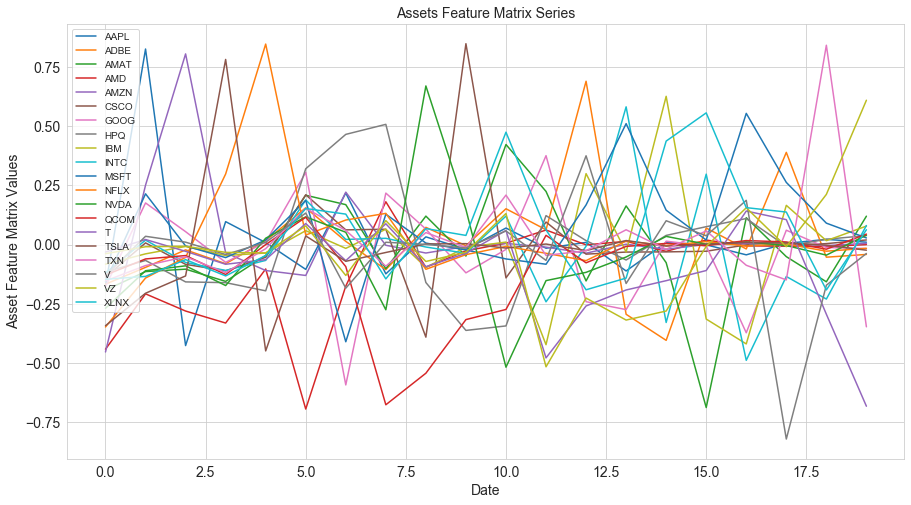

In [72]:
fig,ax=plt.subplots(1)
for i in index:
    df.loc[i,:].plot(ax=ax,fontsize=14)
    print(df.loc[i,:].mean())
ax.legend(index)
ax.set_ylabel('Asset Feature Matrix Values', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title("Assets Feature Matrix Series",fontsize=14)
fig.set_size_inches(15, 8) 

## PCA

In [73]:
from sklearn.decomposition import PCA
pca = PCA(1,random_state=0).fit(df.transpose())
pca.components_[0]

array([-0.        ,  0.17389256,  0.11859759,  0.25865159, -0.5118382 ,
       -0.03604569,  0.05692416, -0.24448464, -0.0256003 , -0.27432461,
        0.08913426,  0.36773363,  0.23922506,  0.13795812, -0.37113684,
       -0.0675823 , -0.28712948, -0.14851943, -0.11498311, -0.08443249])

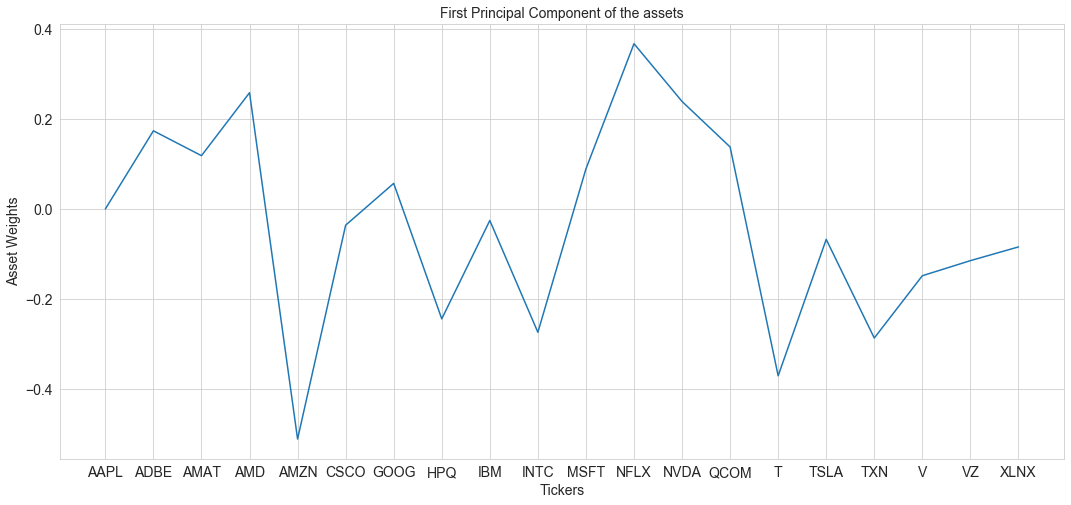

In [74]:
fig, axes = plt.subplots(1)
pc1 = pd.Series(index=ticks, data=pca.components_[0])
pc1.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='First Principal Component of the assets',fontsize=14)
axes.set_ylabel('Asset Weights', fontsize=14)
axes.set_xlabel('Tickers', fontsize=14)
axes.set_title("First Principal Component of the assets",fontsize=14)
fig.set_size_inches(18, 8) 

In [75]:
pc1.sort_values()

AMZN   -0.511838
T      -0.371137
TXN    -0.287129
INTC   -0.274325
HPQ    -0.244485
V      -0.148519
VZ     -0.114983
XLNX   -0.084432
TSLA   -0.067582
CSCO   -0.036046
IBM    -0.025600
AAPL   -0.000000
GOOG    0.056924
MSFT    0.089134
AMAT    0.118598
QCOM    0.137958
ADBE    0.173893
NVDA    0.239225
AMD     0.258652
NFLX    0.367734
dtype: float64

Text(0.5, 1.0, 'Top 10 assets')

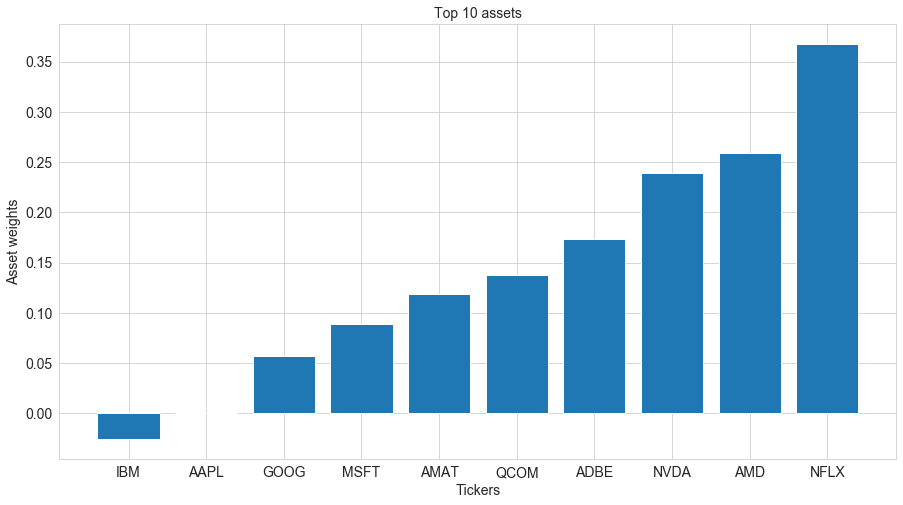

In [76]:
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(15, 8))
plt.bar(pc1.sort_values().index[-10:],pc1.sort_values().values[-10:])
plt.ylabel('Asset weights', fontsize=14)
plt.xlabel('Tickers', fontsize=14)
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)
plt.title("Top 10 assets",fontsize=14)

## ICA

In [77]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=10,random_state=0).fit(df.transpose().fillna(0))


[*********************100%***********************]  20 of 20 completed


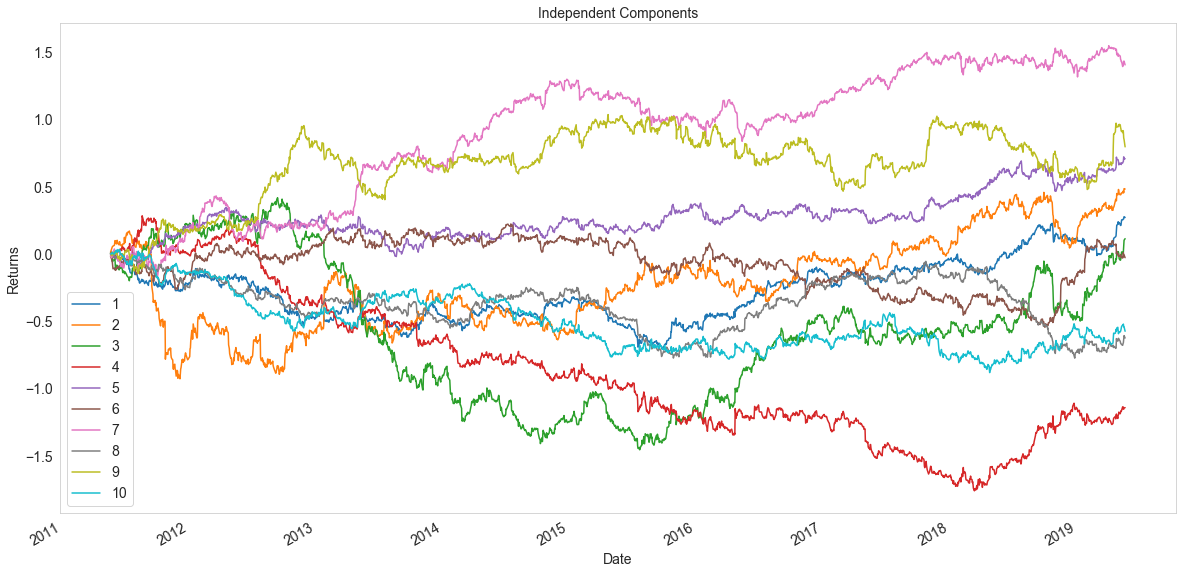

In [103]:
fig, ax = plt.subplots(1, figsize=(20, 10)) 
pan = yf.download(tickers, start="2011-05-20", end="2019-05-21")
ret = pan["Adj Close"].apply(np.log).diff(1)
for i in range(10):
    ret.dot(ica.components_[i]).cumsum().plot(ax=ax,fontsize=14)
ax.legend([str(i) for i in range(1,11,1)],fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title("Independent Components",fontsize=14)
ax.grid()


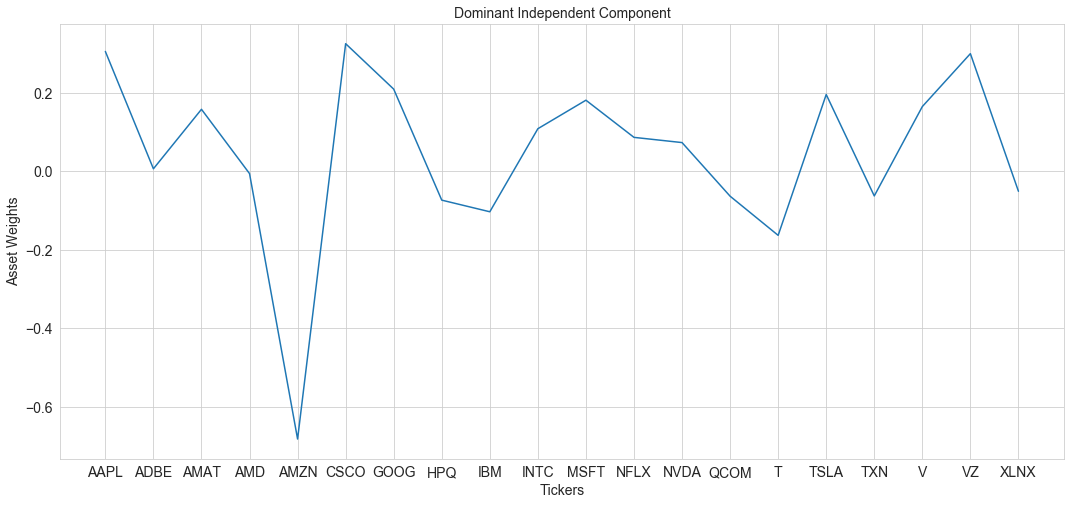

In [79]:
fig, axes = plt.subplots(1)


ica_tech = pd.Series(index=ticks, data=ica.components_[6])
ica_tech.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='Dominant Independent Component',fontsize=14)
axes.set_ylabel('Asset Weights', fontsize=14)
axes.set_xlabel('Tickers', fontsize=14)
axes.set_title('Dominant Independent Component',fontsize=14)

fig.set_size_inches(18, 8) 

In [80]:
ica_tech.sort_values()

AMZN   -0.681950
T      -0.162906
IBM    -0.102825
HPQ    -0.073174
QCOM   -0.063120
TXN    -0.062467
XLNX   -0.050581
AMD    -0.005522
ADBE    0.006711
NVDA    0.073498
NFLX    0.086778
INTC    0.108837
AMAT    0.158302
V       0.165274
MSFT    0.181471
TSLA    0.195967
GOOG    0.209690
VZ      0.300111
AAPL    0.305752
CSCO    0.325499
dtype: float64

Text(0.5, 1.0, 'Top 10 assets')

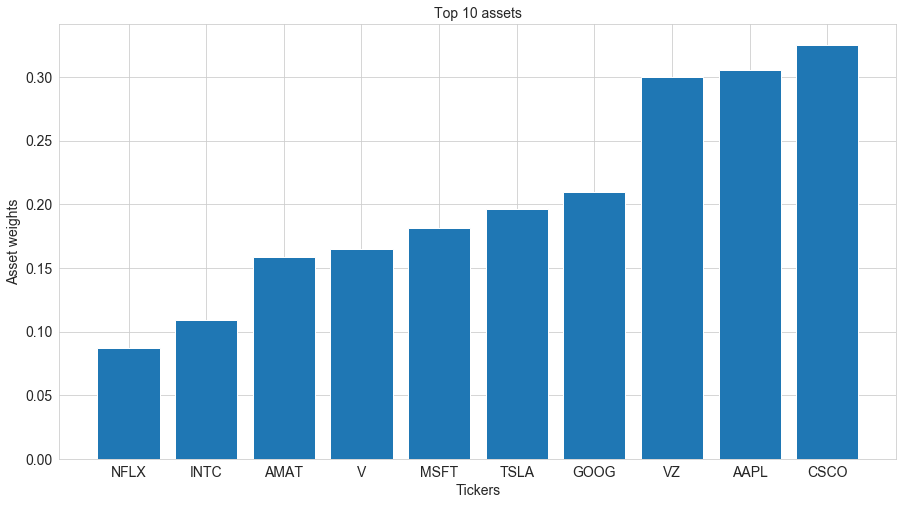

In [81]:
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(15, 8))
plt.bar(ica_tech.sort_values().index[-10:],ica_tech.sort_values().values[-10:])
plt.ylabel('Asset weights', fontsize=14)
plt.xlabel('Tickers', fontsize=14)
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)
plt.title("Top 10 assets",fontsize=14)

# Testing

In [82]:
test = yf.download(tickers, start="2019-05-19", end="2021-05-20")
# test = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2019-05-19", end="2021-05-20")

returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  20 of 20 completed


date        asset
2019-05-21  AAPL     0.018989
            ADBE     0.009467
            AMAT     0.022545
            AMD      0.024802
            AMZN    -0.000780
                       ...   
2021-05-19  TSLA    -0.025253
            TXN      0.015808
            V       -0.004354
            VZ      -0.004557
            XLNX     0.024732
Length: 10080, dtype: float64

## PCA

In [83]:
mean_returns = []

for i in range(0,len(returns_test),len(ticks)):
    mean_returns.append(returns_test[i:i+len(ticks)].values.dot(abs(pca.components_[0])/sum(abs(pca.components_[0]))).mean())
mean_returns

[0.014135517043817238,
 -0.007178707038630822,
 -0.015242178597935061,
 0.0015821272667695726,
 0.0010281131357159899,
 -0.008336675278933515,
 0.002795602291019385,
 -0.02228128408660261,
 -0.011942737406428997,
 0.03548816869750996,
 0.0037515147509459253,
 0.014871941451570244,
 0.014108995099420384,
 0.010363512825209286,
 0.001553975936695927,
 -0.010914754783644417,
 0.0022127837428293482,
 -0.0106995567995641,
 0.001533663250412737,
 0.02249446601690601,
 0.005878933930109713,
 0.006853135169785875,
 -0.003998066771696734,
 0.0028816217294878005,
 -0.015259572613679617,
 0.015628919335799178,
 0.010238704163662944,
 0.0007215833655948586,
 0.01292899269811617,
 0.00029251419765154586,
 0.005456352977759919,
 -0.0010498294532640985,
 -0.004553322098272082,
 0.006267350374431465,
 0.008710372416669145,
 0.0008262587605374141,
 0.00779499118439029,
 0.004411617452569155,
 -0.006358090828299736,
 -0.003415810847035647,
 -0.009492361060418706,
 -0.00823483654945914,
 0.00521956411898

In [84]:
df_ret = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

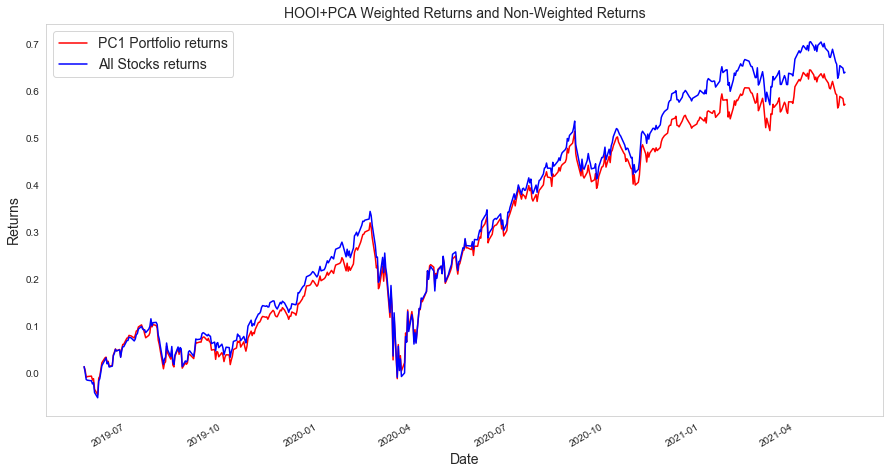

In [85]:
mean_pca = test["Adj Close"].apply(np.log).diff(1).mean(1)
fig,ax = plt.subplots(1,figsize=(15, 8))
df_ret.cumsum().plot(ax=ax, style='r-')
mean_pca.cumsum().plot(ax=ax, style='b-')
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.legend(['PC1 Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("HOOI+PCA Weighted Returns and Non-Weighted Returns",fontsize=14)

ax.grid()

HOOI+PCA


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,27.313%
Cumulative returns,62.085%
Annual volatility,29.769%
Sharpe ratio,0.96
Calmar ratio,0.90
Stability,0.89
Max drawdown,-30.361%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.36,2020-02-19,2020-03-16,2020-07-09,102
1,11.71,2020-09-02,2020-09-23,2020-12-01,65
2,9.55,2019-07-24,2019-08-23,2019-11-07,77
3,8.95,2021-02-12,2021-03-08,2021-04-05,37
4,7.89,2021-04-15,2021-05-12,NaT,NaN


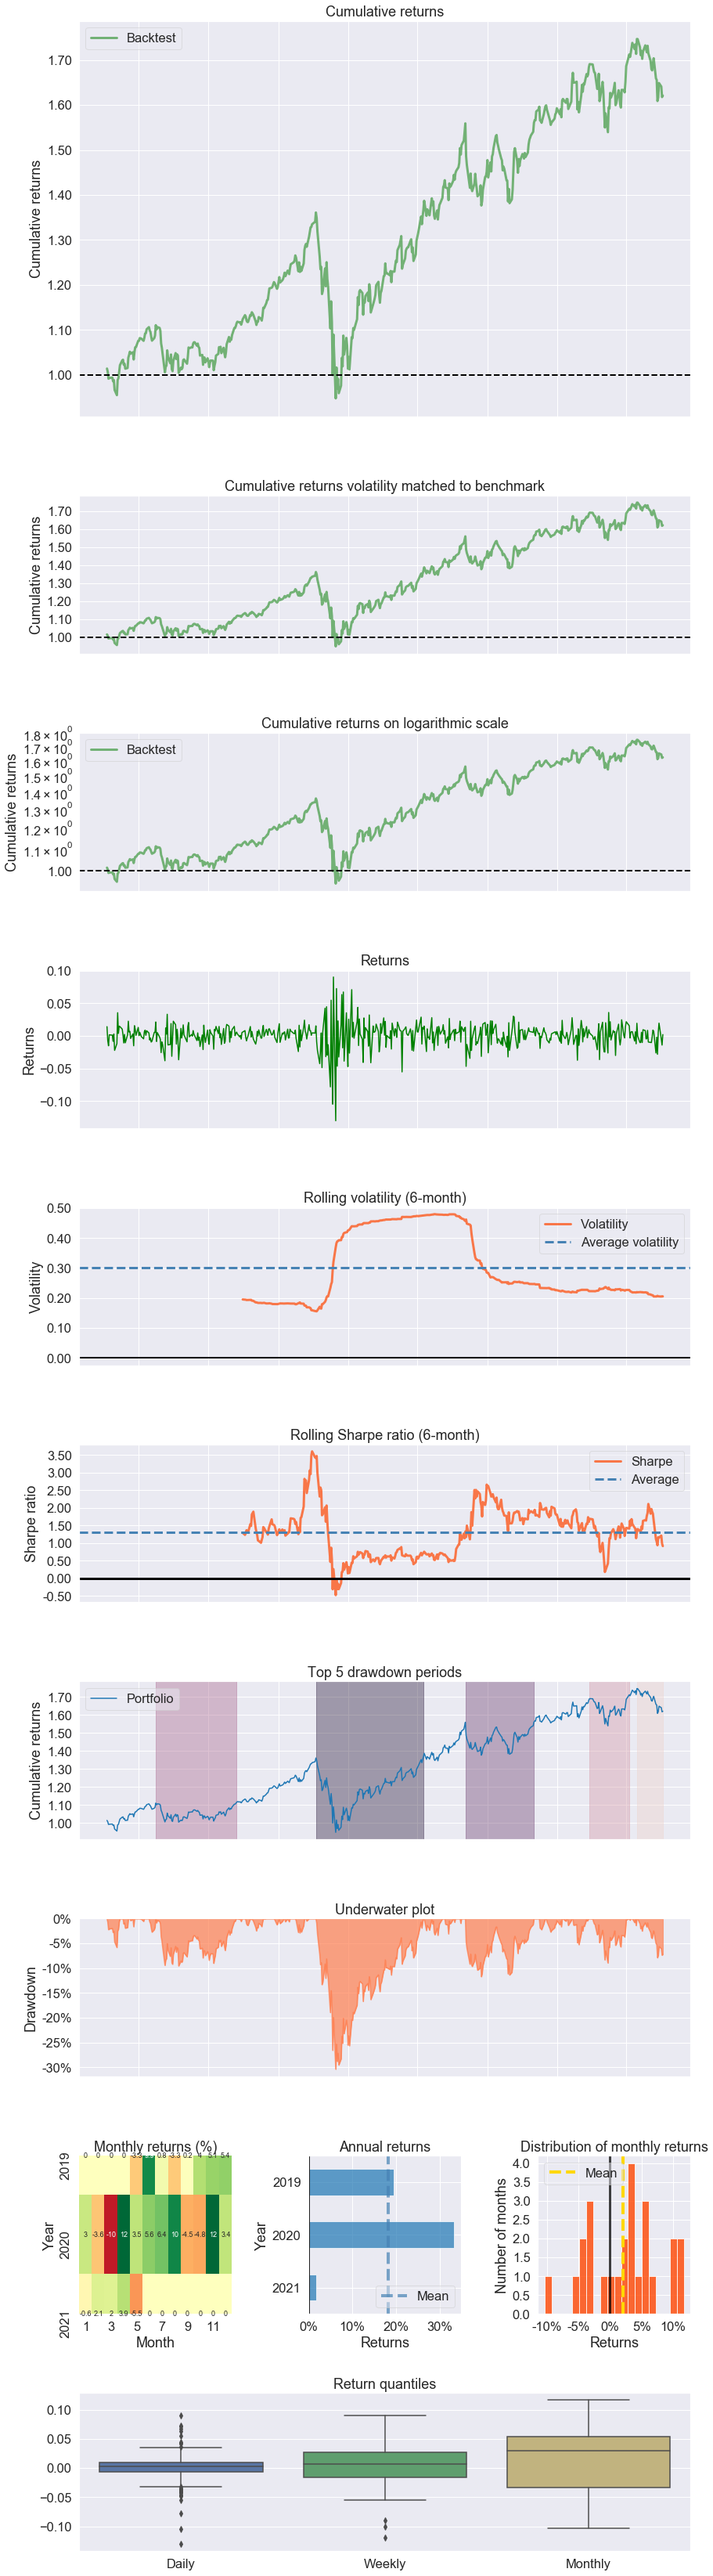

In [86]:
import pyfolio as pf
print("HOOI+PCA")
pf.create_returns_tear_sheet(df_ret)

## ICA

In [87]:
mean_returns = []

for i in range(0,len(returns_test),len(ticks)):
    mean_returns.append(returns_test[i:i+len(ticks)].values.dot(ica_tech).mean())
mean_returns

[0.015176329089029116,
 -0.017357243840751217,
 -0.0023320925344002736,
 -0.008776025115132051,
 -0.012170855166182045,
 -0.005794336152579082,
 -0.0019943345680416076,
 -0.02068322121228024,
 0.0022871873423323135,
 0.03629707018681319,
 0.022963913158660292,
 0.01834393484418452,
 0.0025068589273692776,
 -0.002877536352442571,
 0.012137622915463846,
 -0.017777501824506294,
 0.002776353663114356,
 -0.006437266904109064,
 0.008258984777336699,
 0.011154812187758222,
 0.0031058456356735844,
 0.0035666168582297567,
 0.0069727515903108914,
 0.0014602202339099092,
 -0.019700970365581473,
 0.0026090588683505187,
 -0.0022141086015180066,
 -0.002544956738846828,
 0.0021362202220763875,
 0.009267474562325372,
 0.021867725581290652,
 -0.006566662208573385,
 -0.0221389129862362,
 -0.00849432212791952,
 0.019094979901867152,
 0.011862729708415218,
 0.010013068479812485,
 0.004725813876571575,
 -0.006457738712587947,
 0.005243003340513101,
 0.005523006071505635,
 -0.008055731411724526,
 0.01192452

In [88]:
df_w = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

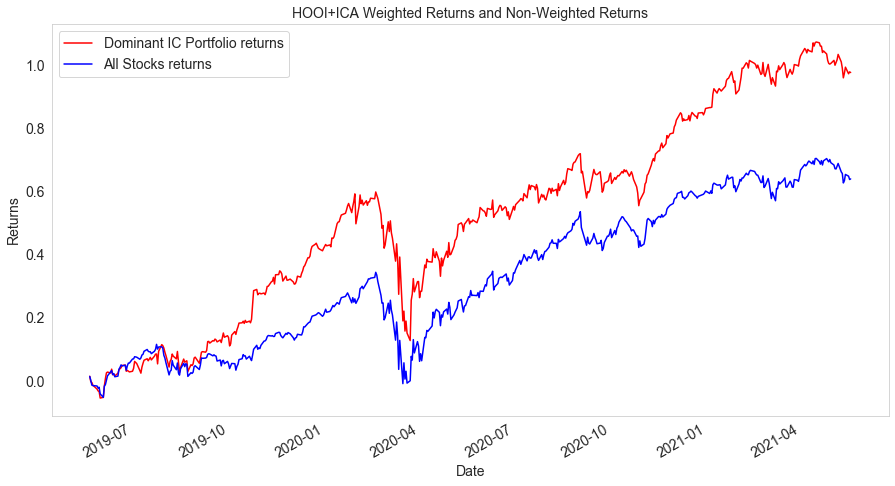

In [89]:
mean_ica = test["Adj Close"].apply(np.log).diff(1).mean(1)
fig,ax = plt.subplots(1,figsize=(15, 8))
df_w.cumsum().plot(ax=ax, style='r-')
mean_ica.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.legend(['Dominant IC Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("HOOI+ICA Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.grid()

HOOI+ICA


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,51.331%
Cumulative returns,129.012%
Annual volatility,38.207%
Sharpe ratio,1.28
Calmar ratio,1.25
Stability,0.88
Max drawdown,-41.088%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,41.09,2020-01-30,2020-03-23,2020-08-28,152
1,16.19,2020-09-02,2020-10-28,2020-11-18,56
2,10.92,2021-04-16,2021-05-12,NaT,NaN
3,8.67,2019-07-29,2019-08-15,2019-09-11,33
4,8.17,2021-02-11,2021-03-08,2021-04-01,36


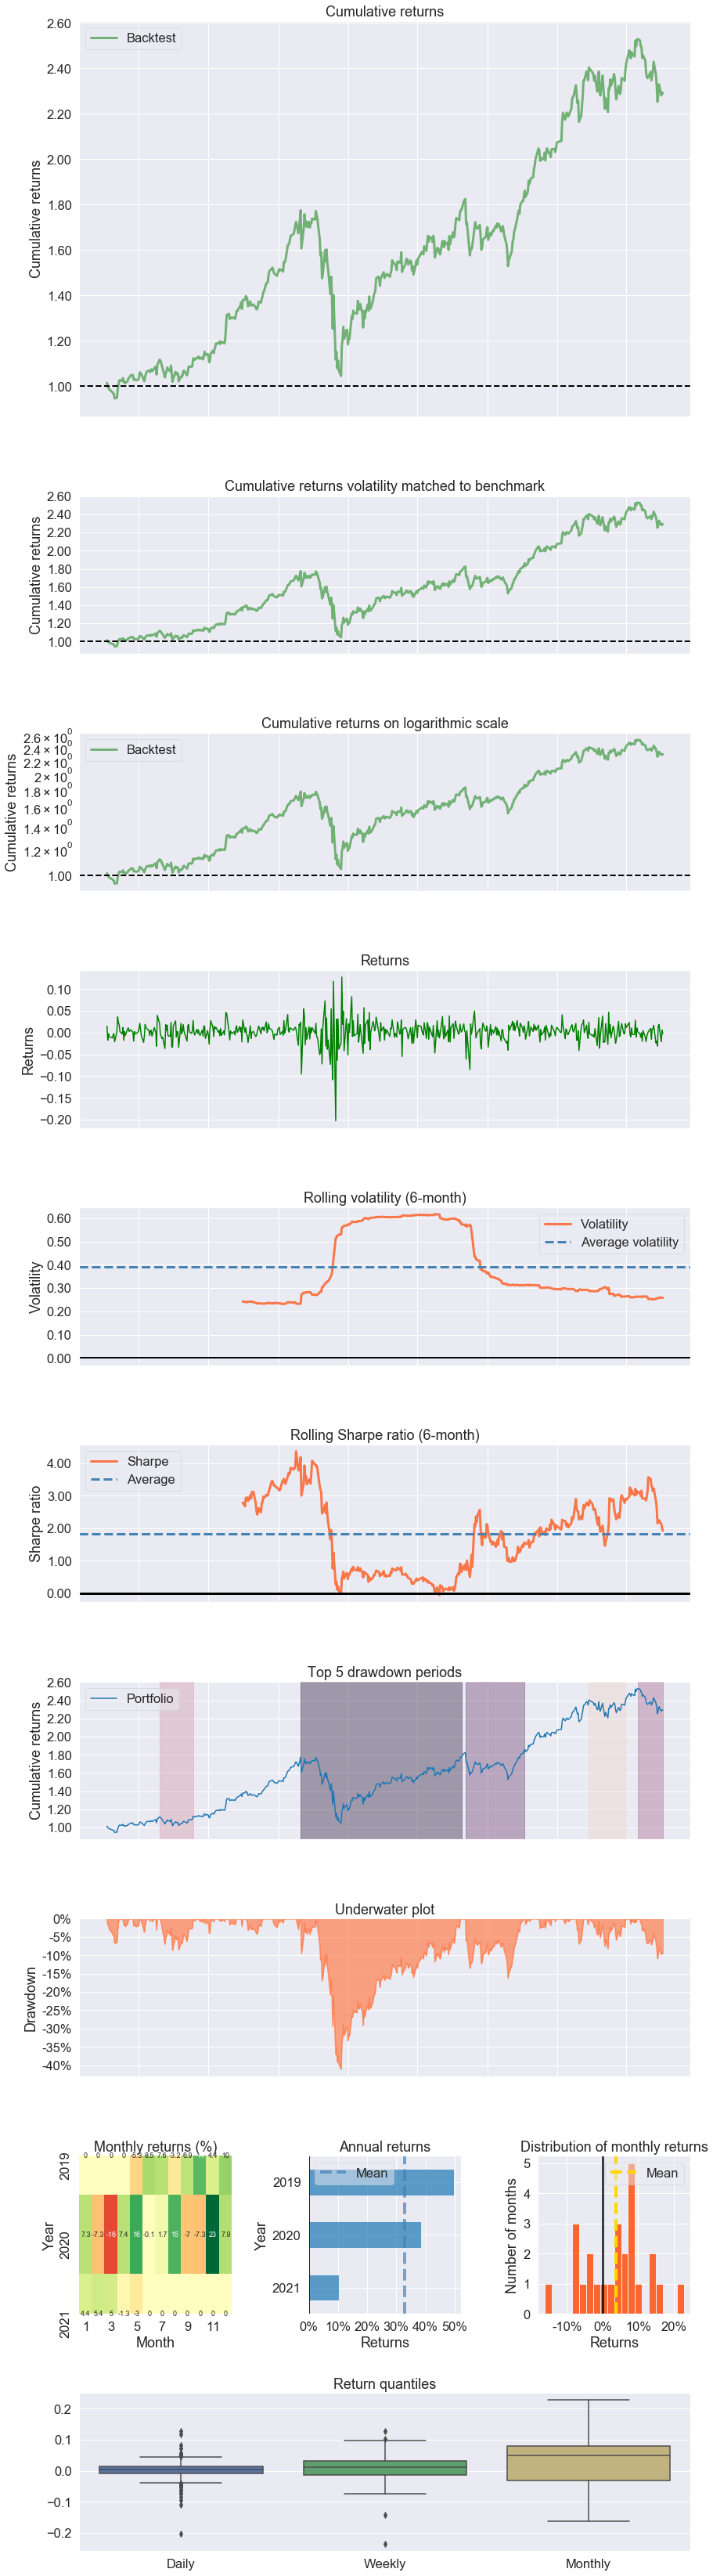

In [90]:
import pyfolio as pf
print("HOOI+ICA")
pf.create_returns_tear_sheet(df_w)

# Top 10

## PCA

In [91]:
dominant_assets = pc1.sort_values().index[-10:]
dominant_assets = " ".join(dominant_assets)
dominant_assets

'IBM AAPL GOOG MSFT AMAT QCOM ADBE NVDA AMD NFLX'

In [92]:
test = yf.download(dominant_assets, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AAPL     0.018989
            ADBE     0.009467
            AMAT     0.022545
            AMD      0.024802
            GOOG     0.009421
                       ...   
2021-05-19  IBM     -0.005016
            MSFT     0.002471
            NFLX     0.002916
            NVDA     0.003561
            QCOM     0.013484
Length: 5040, dtype: float64

In [93]:
mean_returns = []
for i in range(0,len(returns_test),10):
    mean_returns.append(returns_test[i:i+10].mean())
mean_returns

[0.015415100414510751,
 -0.013043550430148265,
 -0.021666746518217962,
 -0.005593790366228868,
 0.005271436377282645,
 -0.011001782765909818,
 0.003594579917704266,
 -0.01781587826545574,
 -0.016542700433744527,
 0.04027780444152116,
 0.0017649517512364544,
 0.01698376597601934,
 0.015478262675464727,
 0.013878611985406852,
 0.001183324611542602,
 -0.01446748495253809,
 0.0012987794806608387,
 -0.011779869135225596,
 0.00019325788212292138,
 0.026253827903406135,
 0.007970833584451009,
 0.009872601194082042,
 -0.0041906895497774155,
 0.0009683645703721488,
 -0.018904778999020034,
 0.018421315149071173,
 0.011788024450959033,
 -0.0005648412256355151,
 0.017626632185454884,
 -0.0021373022977596357,
 0.006098755259586852,
 -0.0025643472642301822,
 -0.007050616358087902,
 0.0060865447570883635,
 0.00781904905550932,
 0.0023426092167951663,
 0.006703059373339126,
 0.003301226204413954,
 -0.004364234181433391,
 -0.00048630948768786376,
 -0.004139733484046148,
 -0.009379085262835974,
 0.01335

In [94]:
df_pca10 = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

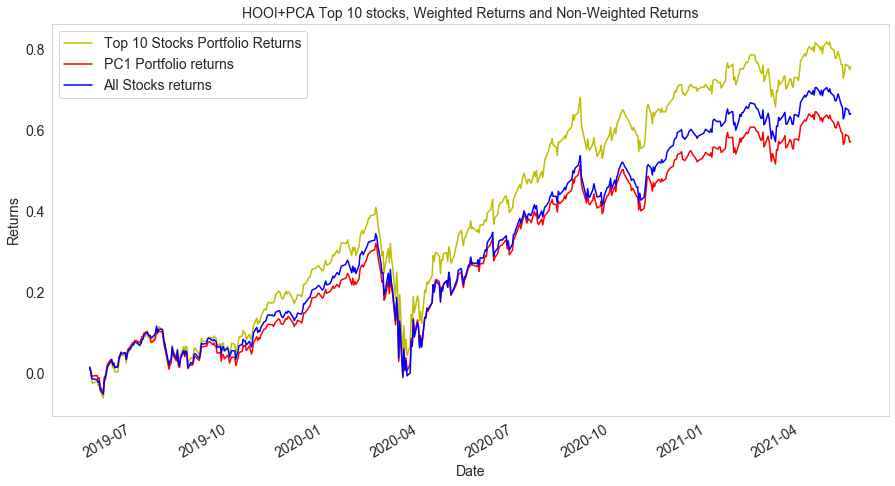

In [95]:
fig,ax = plt.subplots(1,figsize=(15, 8))
df_pca10.cumsum().plot(ax=ax, style='y-')
df_ret.cumsum().plot(ax=ax, style='r-')
mean_pca.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.legend(['Top 10 Stocks Portfolio Returns','PC1 Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("HOOI+PCA Top 10 stocks, Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.grid()

HOOI+PCA- top 10


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,37.719%
Cumulative returns,89.664%
Annual volatility,33.879%
Sharpe ratio,1.12
Calmar ratio,1.12
Stability,0.91
Max drawdown,-33.678%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.68,2020-02-19,2020-03-20,2020-07-09,102
1,14.44,2020-09-02,2020-09-23,2020-12-02,66
2,12.41,2021-02-12,2021-03-08,2021-04-08,40
3,9.91,2019-07-26,2019-08-05,2019-10-28,67
4,8.65,2021-04-29,2021-05-12,NaT,NaN


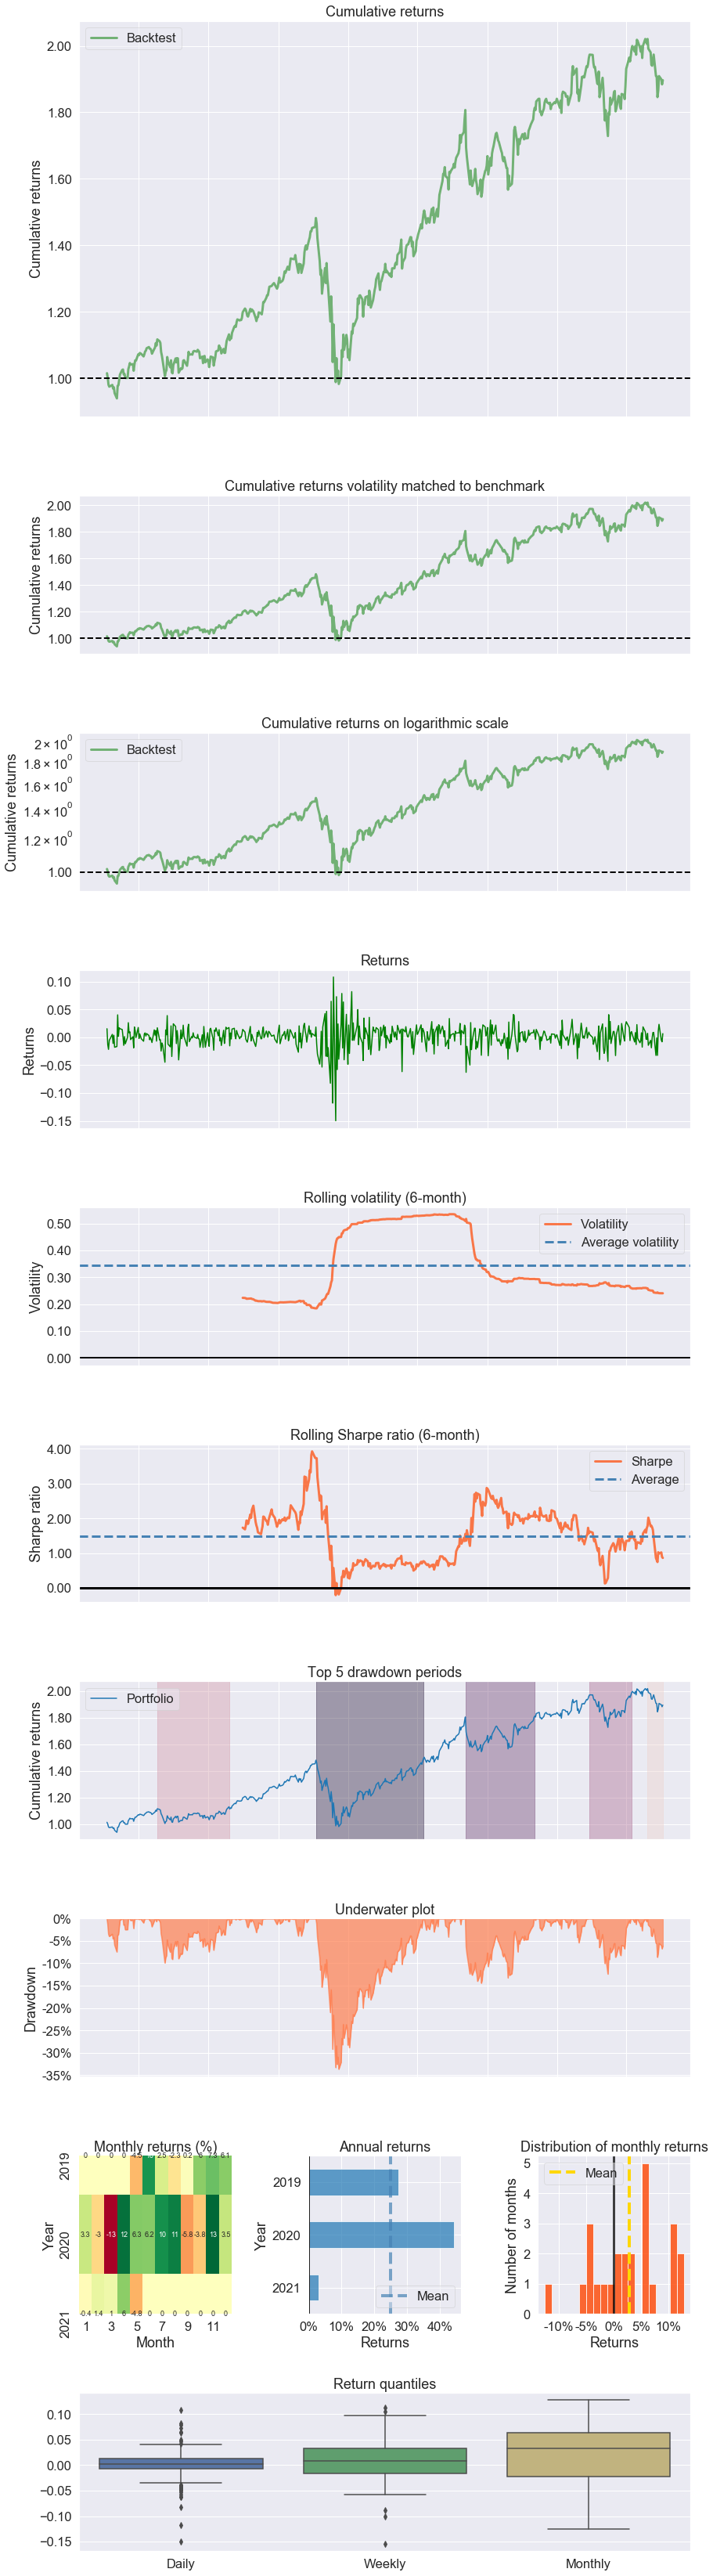

In [96]:
import pyfolio as pf
print("HOOI+PCA- top 10")
pf.create_returns_tear_sheet(df_pca10)

## ICA

In [97]:
num_assets = len(ica.components_[0])//2
dominant_assets_ica = ica_tech.sort_values().index[-num_assets:]
dominant_assets_ica = " ".join(dominant_assets_ica)
dominant_assets_ica

'NFLX INTC AMAT V MSFT TSLA GOOG VZ AAPL CSCO'

In [98]:
test = yf.download(dominant_assets_ica, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AAPL     0.018989
            AMAT     0.022545
            CSCO     0.009064
            GOOG     0.009421
            INTC     0.020450
                       ...   
2021-05-19  MSFT     0.002471
            NFLX     0.002916
            TSLA    -0.025253
            V       -0.004354
            VZ      -0.004557
Length: 5040, dtype: float64

In [99]:
mean_returns = []
for i in range(0,len(returns_test),num_assets):
    mean_returns.append(returns_test[i:i+num_assets].mean())
mean_returns

[0.011267165845048544,
 -0.010096157772497883,
 -0.009735981081579448,
 -0.0021073412728489505,
 -0.005920324912330921,
 -0.00459578144826569,
 0.0016583884357071366,
 -0.021385034429803572,
 -0.01544287351656064,
 0.03261373634153726,
 0.01089811668802949,
 0.013876895613759955,
 0.012965994360452936,
 0.009957440509143777,
 0.006003415233210951,
 -0.01320888815669181,
 0.00414175196239217,
 -0.004907800701003495,
 0.007388292895238058,
 0.014271291505050776,
 0.0038862423379332433,
 0.005318270902892985,
 0.0026143418780203652,
 0.0014547997389610322,
 -0.018450391123510414,
 0.007810173384052899,
 0.0035276795806381766,
 -0.0003806535821100798,
 0.009758528384143483,
 0.004662192132112964,
 0.012136204201440348,
 -0.0026323010439274876,
 -0.00933420483948888,
 0.0025119924674709805,
 0.01340743103560782,
 0.0024664554344727475,
 0.008939367469912885,
 0.003878484026069673,
 -0.006231819247218206,
 -0.00201515536536534,
 -0.0032084340101654176,
 -0.006686603227150955,
 0.009364802313

In [100]:
df_ica10 = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

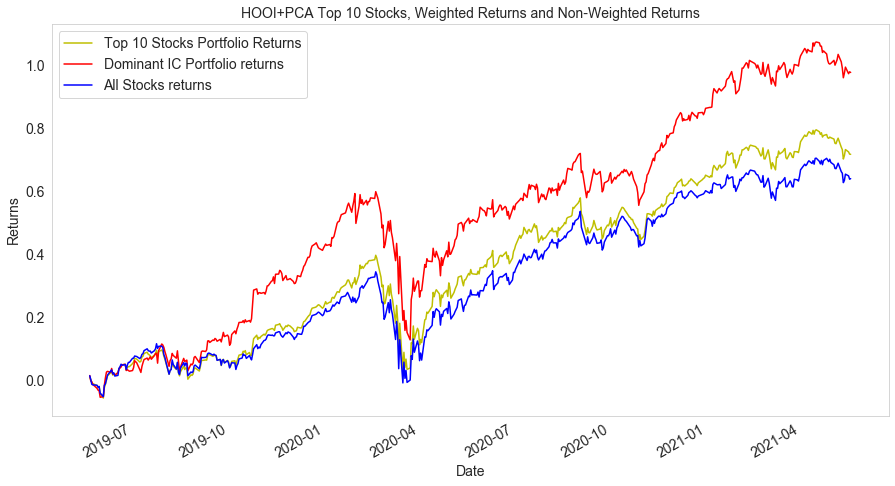

In [101]:
fig,ax = plt.subplots(1,figsize=(15, 8))
df_ica10.cumsum().plot(ax=ax, style='y-')
df_w.cumsum().plot(ax=ax, style='r-')
mean_ica.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.legend(['Top 10 Stocks Portfolio Returns','Dominant IC Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("HOOI+PCA Top 10 Stocks, Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.grid()

HOOI+ICA- top 10


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,36.541%
Cumulative returns,86.434%
Annual volatility,30.619%
Sharpe ratio,1.17
Calmar ratio,1.11
Stability,0.91
Max drawdown,-33.056%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.06,2020-02-19,2020-03-20,2020-07-06,99
1,13.32,2020-09-02,2020-10-28,2020-11-27,63
2,9.13,2019-07-29,2019-08-23,2019-10-24,64
3,8.97,2021-04-16,2021-05-12,NaT,NaN
4,7.79,2021-02-12,2021-03-08,2021-04-01,35


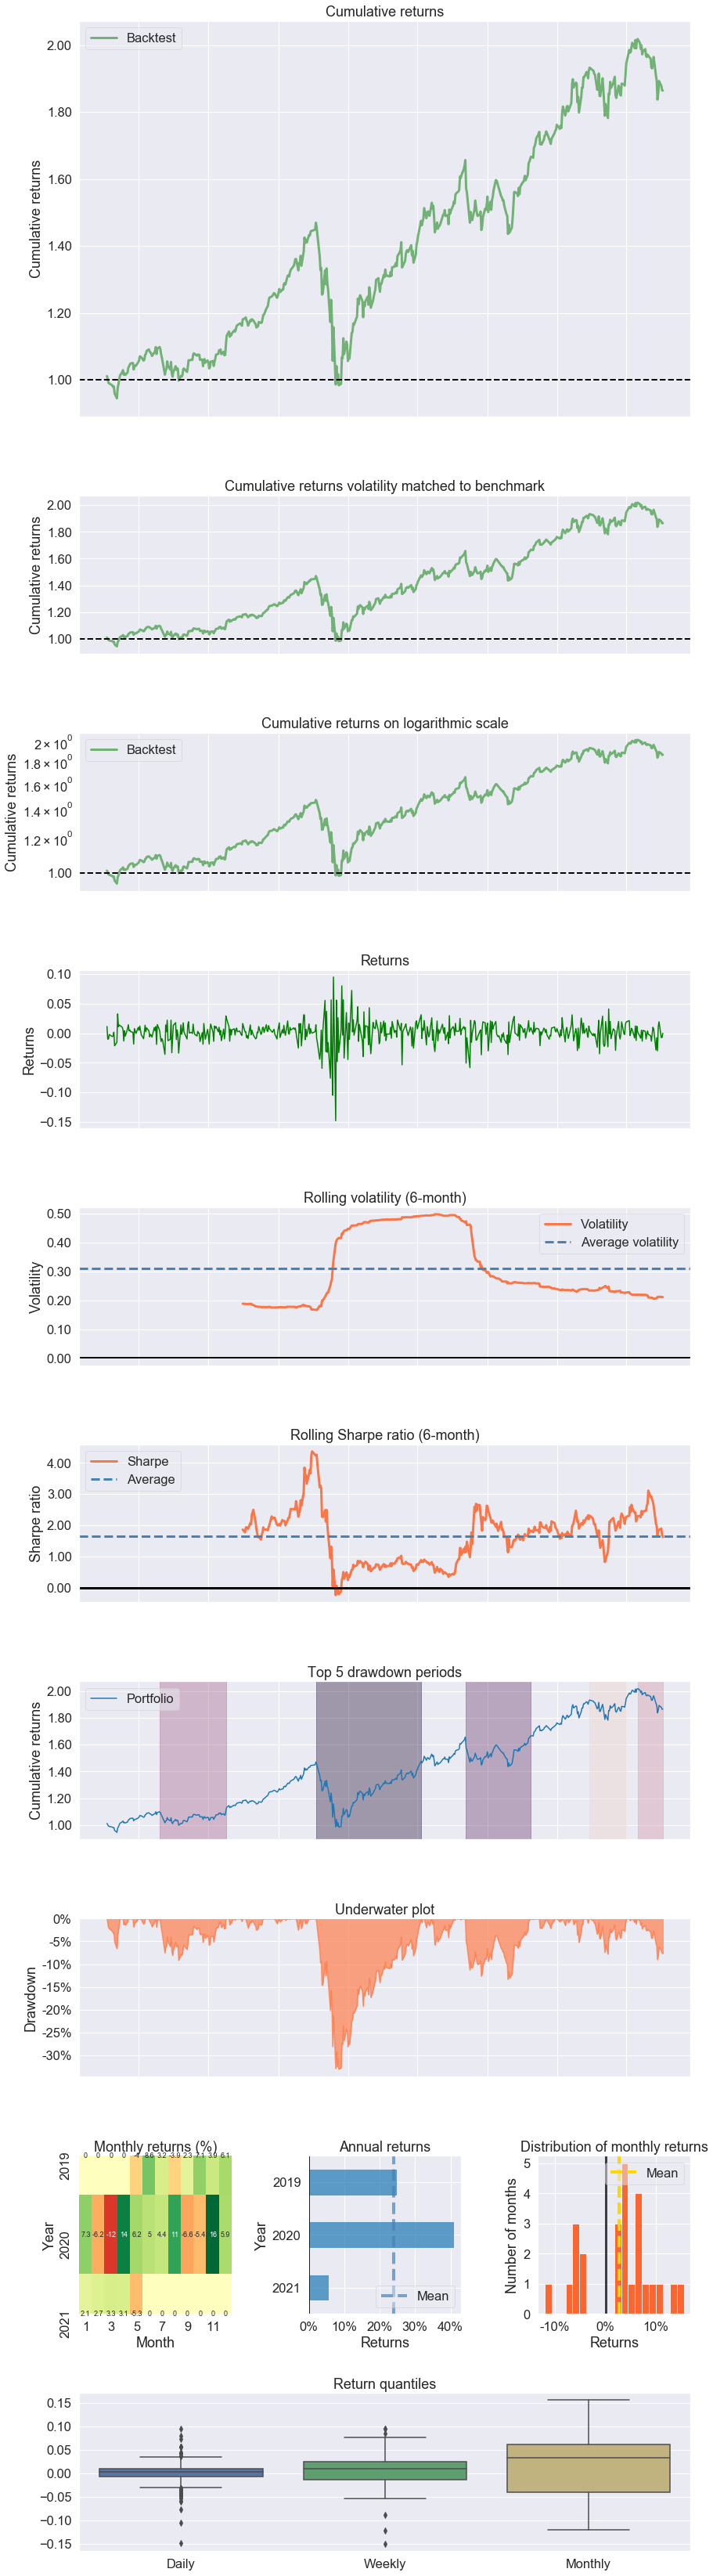

In [102]:
import pyfolio as pf
print("HOOI+ICA- top 10")
pf.create_returns_tear_sheet(df_ica10)